### Prediction of scraped MyAnimeList Data ###

In [100]:
from sklearn import datasets
import numpy as np
import pandas as pd

In [101]:
import warnings
warnings.filterwarnings('ignore')

In [102]:
df = pd.read_csv("anime_df_raw.csv", sep=';')
df.head(10)

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),3,9.15,Shounen,2009
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),220,9.15,Shounen,2022
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,PG-13 - Teens 13 or older,13,9.09,N\A,2011
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,335,9.09,Shounen,2015
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),32,9.08,Shounen,2019
5,5,Fruits Basket: The Final,42938,TV,13,23 min. per ep.,TMS Entertainment,Manga,"Drama,Romance,Slice of Life,Supernatural",N\A,PG-13 - Teens 13 or older,626,9.06,Shoujo,2021
6,6,Gintama',9969,TV,51,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,380,9.06,Shounen,2011
7,7,Gintama: The Final,39486,Movie,1,1 hr. 44 min.,Bandai Namco Pictures,Manga,"Action,Comedy,Drama,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,1798,9.05,Shounen,2021
8,8,Hunter x Hunter (2011),11061,TV,148,23 min. per ep.,Madhouse,Manga,"Action,Adventure,Fantasy",N\A,PG-13 - Teens 13 or older,10,9.05,Shounen,2011
9,9,Gintama': Enchousen,15417,TV,13,24 min. per ep.,Sunrise,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,683,9.04,Shounen,2012


delete null information. (if exists)

In [103]:
data_null_total = pd.DataFrame(df.isna().sum()).T.rename({0:'total null'})
data_null_total

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
total null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204


get info.

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9497 entries, 0 to 9496
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          9497 non-null   int64  
 1   Title               9497 non-null   object 
 2   MAL Id              9497 non-null   int64  
 3   Type                9497 non-null   object 
 4   Number of Episodes  9497 non-null   object 
 5   Episode Duration    9497 non-null   object 
 6   Studios             9497 non-null   object 
 7   Source Type         9497 non-null   object 
 8   Genres              9497 non-null   object 
 9   Themes              9497 non-null   object 
 10  Rating              9497 non-null   object 
 11  Popularity          9497 non-null   int64  
 12  Score               9497 non-null   float64
 13  Demographic         9497 non-null   object 
 14  Year                9293 non-null   object 
dtypes: float64(1), int64(3), object(11)
memory usage: 1.1+ 

check for duplicated data. (if there is)

In [105]:
df = df.drop_duplicates(keep='first')

Lets remove entries with 'None' data.

'add some' is a placeholder of shows without a known studio. <br>
'Unknown'

In [106]:
no_studio = df[df['Studios'].str.contains('add some')]
df = pd.concat([df, no_studio])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_studio.index)) )

Removed 1163 entries.


In [107]:
no_source = df[df['Source Type'].str.contains('Unknown')]
df = pd.concat([df, no_source])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_source.index)) )

Removed 853 entries.


In [108]:
no_genre = df[df['Genres'] == 'N\A']
df = pd.concat([df, no_genre])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_genre.index)) )

Removed 1548 entries.


In [109]:
clean_df = df[pd.to_numeric(df['Year'], errors='coerce').notnull()]

print( 'Removed {} entries.'.format(len(df.index) - len(clean_df.index)) )
df = clean_df

Removed 41 entries.


In [110]:
df

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,Rating,Popularity,Score,Demographic,Year
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,R - 17+ (violence & profanity),3,9.15,Shounen,2009
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),220,9.15,Shounen,2022
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,PG-13 - Teens 13 or older,13,9.09,N\A,2011
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",PG-13 - Teens 13 or older,335,9.09,Shounen,2015
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",R - 17+ (violence & profanity),32,9.08,Shounen,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9480,9480,Sora to Umi no Aida,36000,TV,12,23 min. per ep.,TMS Entertainment,Game,"Adventure,Fantasy,Sci-Fi",N\A,PG-13 - Teens 13 or older,4139,5.66,N\A,2018
9483,9483,Tuzki: Love Assassin,23903,ONA,1,2 min.,Studio 4°C,Other,"Comedy,Romance",N\A,R - 17+ (violence & profanity),11502,5.66,N\A,2014
9487,9487,California Crisis: Tsuigeki no Juuka,3127,OVA,1,45 min.,"Studio Unicorn,Hiro Media",Original,"Action,Adventure,Sci-Fi",N\A,PG-13 - Teens 13 or older,7041,5.66,N\A,1986
9491,9491,Hipira-kun ONA,22983,ONA,2,5 min. per ep.,Sunrise,Picture,"Comedy,Fantasy,Supernatural",N\A,PG - Children,11824,5.66,Kids,2010


Parsing Episode Duration to 'int' minutes.

In [111]:
def DurationToMin(duration_str):
    duration_list = duration_str.split(' ')
    duration = 0

    i = 0
    for word in duration_list:
        if word == 'min.':
            duration += int(duration_list[i-1])
        elif word == 'hr.':
            duration += 60*int(duration_list[i-1])
        i += 1

    return duration

In [112]:
df['Duration'] = df['Episode Duration'].apply(lambda x: DurationToMin(x))

Lets remove shows with episode duration smaller than 1 minute.

In [113]:
no_duration = df[df['Duration'] == 0]
df = pd.concat([df, no_duration])
df = df.drop_duplicates(keep=False)

print( 'Removed {} entries.'.format(len(no_duration.index)) )

Removed 19 entries.


Lets separate the genres into their own columns.

In [116]:
genre_list = []
for cell in df['Genres']:
    genres = cell.split(',')
    for genre in genres:
        if genre not in genre_list:
            genre_list.append(genre)

for genre in genre_list:
    df[genre] = df.apply (lambda row: genre in row['Genres'], axis=1)

df.to_csv("anime_df_clean.csv", sep=';', index=False)

print( 'There are {} genres.'.format(len(genre_list)) )

There are 20 genres.


In [115]:
df

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,...,Supernatural,Sports,Award Winning,Ecchi,Horror,Avant Garde,Boys Love,Gourmet,Girls Love,Work Life
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,...,False,False,False,False,False,False,False,False,False,False
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,False,False,False,False,False,False,False,False,False,False
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,...,False,False,False,False,False,False,False,False,False,False
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",...,False,False,False,False,False,False,False,False,False,False
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9480,9480,Sora to Umi no Aida,36000,TV,12,23 min. per ep.,TMS Entertainment,Game,"Adventure,Fantasy,Sci-Fi",N\A,...,False,False,False,False,False,False,False,False,False,False
9483,9483,Tuzki: Love Assassin,23903,ONA,1,2 min.,Studio 4°C,Other,"Comedy,Romance",N\A,...,False,False,False,False,False,False,False,False,False,False
9487,9487,California Crisis: Tsuigeki no Juuka,3127,OVA,1,45 min.,"Studio Unicorn,Hiro Media",Original,"Action,Adventure,Sci-Fi",N\A,...,False,False,False,False,False,False,False,False,False,False
9491,9491,Hipira-kun ONA,22983,ONA,2,5 min. per ep.,Sunrise,Picture,"Comedy,Fantasy,Supernatural",N\A,...,True,False,False,False,False,False,False,False,False,False


### Graphs ###

<AxesSubplot:title={'center':'Studio and the Number of Published Anime'}>

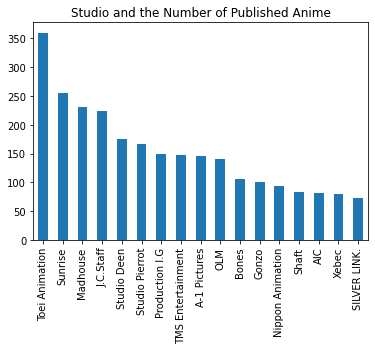

In [123]:
#MAKE MEDIAN STUDIO POPULARITY
#MAKE CHART

import matplotlib.pyplot as plt 

plt.title('Studio and the Number of Published Anime')
studio_appearances = df.Studios.value_counts()
studio_appearances[studio_appearances > 70].plot(kind = 'bar')

<AxesSubplot:title={'center':'Genres and the Number of Published Anime'}>

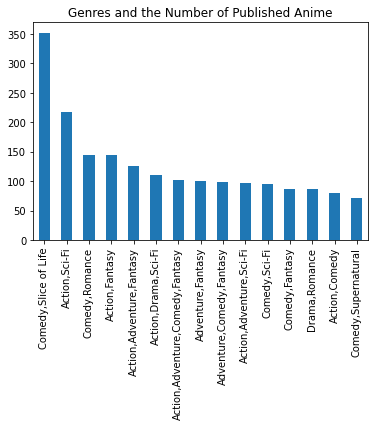

In [125]:

#cut genres
#median genre popularity
#make chart of genre vs populrity


plt.title('Genres and the Number of Published Anime')
genre_appearances = df.Genres.value_counts()
genre_appearances[genre_appearances > 70].plot(kind = 'bar')

<AxesSubplot:title={'center':'How many times each popularity appears modul 5000'}, xlabel='Popularity'>

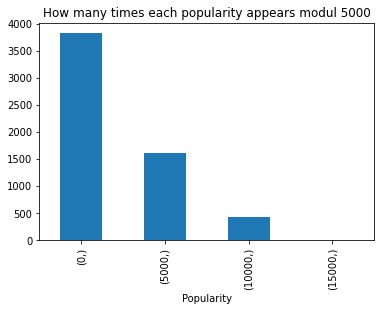

In [135]:
plt.title('How many times each popularity appears modul 5000')
df_popularity = df[['Popularity']].apply(lambda x: (x-(x%5000)))
df_popularity

df_popularity_count = df_popularity.value_counts()
df_popularity_count.plot(kind = 'bar')

<AxesSubplot:title={'center':'Source and the Number of Published Anime'}>

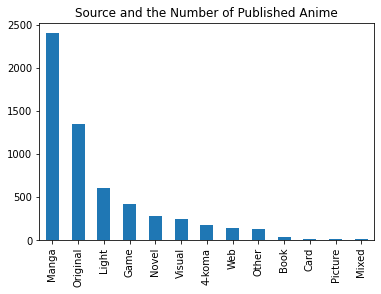

In [127]:
plt.title('Source and the Number of Published Anime')
source_appearances = df['Source Type'].value_counts()
source_appearances[source_appearances>10].plot(kind = 'bar')

In [130]:
df_highpop = df[df['Popularity']>10000]
df_highpop

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,...,Supernatural,Sports,Award Winning,Ecchi,Horror,Avant Garde,Boys Love,Gourmet,Girls Love,Work Life
1381,1381,Ling Long: Incarnation Part 2,42290,ONA,6,30 min. per ep.,YHKT Entertainment,Original,"Action,Drama,Horror,Sci-Fi,Suspense",N\A,...,False,False,False,False,True,False,False,False,False,False
1978,1978,Fanren Xiu Xian Chuan: Fanren Feng Qi Tian Nan Er,42965,ONA,9,20 min. per ep.,"Original Force,Wan Wei Mao Donghua",Novel,"Action,Adventure,Fantasy",N\A,...,False,False,False,False,False,False,False,False,False,False
1979,1979,Fanren Xiu Xian Chuan: Yan Jia Bao Dazhan,45558,ONA,4,18 min. per ep.,"Original Force,Wan Wei Mao Donghua",Novel,"Action,Adventure,Fantasy","Historical,Martial Arts",...,False,False,False,False,False,False,False,False,False,False
1985,1985,Ling Long: Incarnation Final Chapter,44090,ONA,2,38 min. per ep.,YHKT Entertainment,Original,"Action,Drama,Horror,Sci-Fi,Suspense",N\A,...,False,False,False,False,True,False,False,False,False,False
2043,2043,Ling Jian Zun 4th Season,41884,ONA,180,11 min. per ep.,Soyep,Novel,"Action,Adventure,Fantasy,Romance",N\A,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9475,9475,Oniku Daisuki! Zeushi-kun,22541,TV,12,1 min. per ep.,DLE,Original,"Comedy,Gourmet",N\A,...,False,False,False,False,False,False,False,True,False,False
9478,9478,"Slime Boukenki: Umi da, Yeah!",8664,Special,1,15 min.,Production I.G,Game,"Action,Adventure,Comedy,Fantasy",N\A,...,False,False,False,False,False,False,False,False,False,False
9483,9483,Tuzki: Love Assassin,23903,ONA,1,2 min.,Studio 4°C,Other,"Comedy,Romance",N\A,...,False,False,False,False,False,False,False,False,False,False
9491,9491,Hipira-kun ONA,22983,ONA,2,5 min. per ep.,Sunrise,Picture,"Comedy,Fantasy,Supernatural",N\A,...,True,False,False,False,False,False,False,False,False,False


<AxesSubplot:title={'center':'Source and the Number of Published Anime for High Popularity Anime'}>

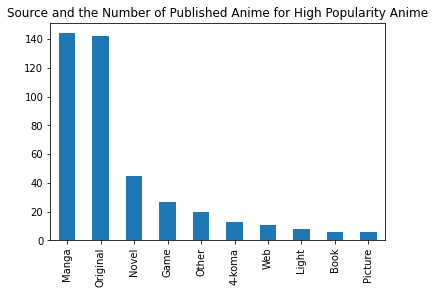

In [131]:
plt.title('Source and the Number of Published Anime for High Popularity Anime')
source_appearances = df_highpop['Source Type'].value_counts()
source_appearances[source_appearances>5].plot(kind = 'bar')

In [132]:
df_lowpop = df[df['Popularity']<2500]
df_lowpop

,Unnamed: 0,Title,MAL Id,Type,Number of Episodes,Episode Duration,Studios,Source Type,Genres,Themes,...,Supernatural,Sports,Award Winning,Ecchi,Horror,Avant Garde,Boys Love,Gourmet,Girls Love,Work Life
0,0,Fullmetal Alchemist: Brotherhood,5114,TV,64,24 min. per ep.,Bones,Manga,"Action,Adventure,Comedy,Drama,Fantasy",N\A,...,False,False,False,False,False,False,False,False,False,False
1,1,Shingeki no Kyojin: The Final Season Part 2,48583,TV,12,23 min. per ep.,MAPPA,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,False,False,False,False,False,False,False,False,False,False
2,2,Steins;Gate,9253,TV,24,24 min. per ep.,White Fox,Visual,"Drama,Sci-Fi,Suspense",N\A,...,False,False,False,False,False,False,False,False,False,False
3,3,Gintama°,28977,TV,51,24 min. per ep.,Bandai Namco Pictures,Manga,"Action,Comedy,Sci-Fi","Historical,Parody,Samurai",...,False,False,False,False,False,False,False,False,False,False
4,4,Shingeki no Kyojin Season 3 Part 2,38524,TV,10,23 min. per ep.,Wit Studio,Manga,"Action,Drama,Fantasy,Mystery","Military,Super Power",...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,9144,Taboo Tattoo,29758,TV,12,24 min. per ep.,J.C.Staff,Manga,"Action,Mystery,Supernatural","Martial Arts,Super Power",...,True,False,False,False,False,False,False,False,False,False
9177,9177,Dokyuu Hentai HxEros,40623,TV,12,23 min. per ep.,Project No.9,Manga,"Action,Comedy,Supernatural,Ecchi",N\A,...,True,False,False,True,False,False,False,False,False,False
9272,9272,Sin: Nanatsu no Taizai,33834,TV,12,23 min. per ep.,"Artland,TNK",Other,"Fantasy,Ecchi",N\A,...,False,False,False,True,False,False,False,False,False,False
9462,9462,Kenja no Deshi wo Nanoru Kenja,42072,TV,12,23 min. per ep.,Studio A-CAT,Light,"Adventure,Fantasy",N\A,...,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:title={'center':'Source and the Number of Published Anime for Low Popularity Anime'}>

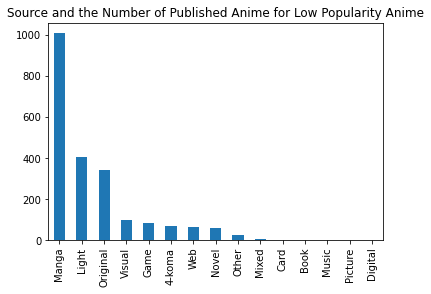

In [133]:
plt.title('Source and the Number of Published Anime for Low Popularity Anime')
source_appearances = df_lowpop['Source Type'].value_counts()
source_appearances.plot(kind = 'bar')

<AxesSubplot:title={'center':'Genres and the Number of Published Anime for High Popularity Anime'}>

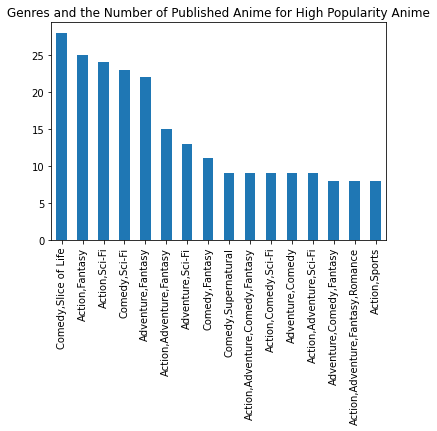

In [134]:
plt.title('Genres and the Number of Published Anime for High Popularity Anime')
genre_appearances = df_highpop.Genres.value_counts()
genre_appearances[genre_appearances > 7.5].plot(kind = 'bar')